In [1]:
import time
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
%matplotlib inline

In [3]:
import torch
import torchvision
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
from torchvision.datasets import ImageFolder
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader):
    start_time = time.time()
    train_loss_list = []
    test_loss_list = []
    for epoch in range(num_epochs):
        print("Epoch {} running".format(epoch))
        model.train()
        running_loss = 0.
        running_corrects = 0 
        # load a batch data of images
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device) 
            # forward inputs and get output
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            # get loss value and update the network weights
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset) * 100.
        train_loss_list.append(epoch_loss)
        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    

        model.eval()
        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(test_dataset)
            epoch_acc = running_corrects / len(test_dataset) * 100.
            test_loss_list.append(epoch_loss)
            print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))
        
    return train_loss_list, test_loss_list      

## Load datasets

In [6]:
train_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

In [7]:
train_dataset = ImageFolder('C:/Users/Aleksei_Bolshukhin/Desktop/computer_vision/2/Classification_data/Classification_data/train',
                      transform = train_transforms)
test_dataset = ImageFolder('C:/Users/Aleksei_Bolshukhin/Desktop/computer_vision/2/Classification_data/Classification_data/test',
                      transform = test_transforms)

(-0.5, 1125.5, 900.5, -0.5)

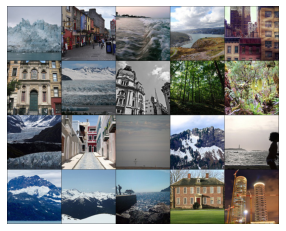

In [8]:
#Generating data loaders from the corresponding datasets
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
full_test_dataloader =  torch.utils.data.DataLoader(test_dataset)
  
#Plotting 20 images from the 1st batch 
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
plt.imshow(np.transpose(torchvision.utils.make_grid(
  images[:20], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')

In [9]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 14034
Test dataset size: 3000
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Train and compare some models

In [10]:
train_loss_dict = {}
test_loss_dict = {}

### model1 - custom CNN

In [11]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            #Input = 3 x 32 x 32, Output = 32 x 32 x 32
            torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1), 
            torch.nn.ReLU(),
            #Input = 32 x 32 x 32, Output = 32 x 16 x 16
            torch.nn.MaxPool2d(kernel_size=2),
  
            #Input = 32 x 16 x 16, Output = 64 x 16 x 16
            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            #Input = 64 x 16 x 16, Output = 64 x 8 x 8
            torch.nn.MaxPool2d(kernel_size=2),
              
            #Input = 64 x 8 x 8, Output = 64 x 8 x 8
            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            #Input = 64 x 8 x 8, Output = 64 x 4 x 4
            torch.nn.MaxPool2d(kernel_size=2),
  
            torch.nn.Flatten(),
            torch.nn.Linear(50176, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 10)
        )
  
    def forward(self, x):
        return self.model(x)

In [12]:
model = CNN().to(device)

num_epochs = 20
learning_rate = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [13]:
train_loss_list, test_loss_list = training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader)

Epoch 0 running
[Train #0] Loss: 1.8769 Acc: 23.4288% Time: 475.2258s
[Test #0] Loss: 1.6397 Acc: 37.3000% Time: 521.9766s
Epoch 1 running
[Train #1] Loss: 1.5036 Acc: 41.4208% Time: 999.7216s
[Test #1] Loss: 1.3450 Acc: 49.5667% Time: 1047.0261s
Epoch 2 running
[Train #2] Loss: 1.2780 Acc: 51.0760% Time: 1524.2995s
[Test #2] Loss: 1.2362 Acc: 53.2333% Time: 1571.3469s
Epoch 3 running
[Train #3] Loss: 1.1859 Acc: 54.7385% Time: 2046.7836s
[Test #3] Loss: 1.1884 Acc: 55.0333% Time: 2094.2489s
Epoch 4 running
[Train #4] Loss: 1.1012 Acc: 57.5745% Time: 2568.8196s
[Test #4] Loss: 1.1087 Acc: 58.2667% Time: 2615.8501s
Epoch 5 running
[Train #5] Loss: 1.0344 Acc: 59.6409% Time: 3095.1383s
[Test #5] Loss: 1.0208 Acc: 61.1333% Time: 3142.6882s
Epoch 6 running
[Train #6] Loss: 0.9766 Acc: 61.9852% Time: 3619.7167s
[Test #6] Loss: 0.9580 Acc: 63.1667% Time: 3667.0390s
Epoch 7 running
[Train #7] Loss: 0.9387 Acc: 63.9661% Time: 4144.6773s
[Test #7] Loss: 0.9464 Acc: 62.8000% Time: 4191.7462s
Epo

Text(0, 0.5, 'Training loss')

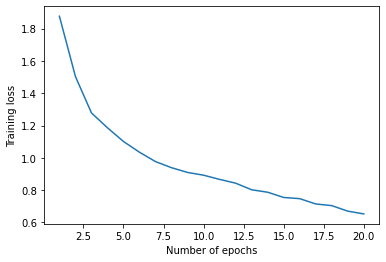

In [14]:
plt.plot(range(1,num_epochs+1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")

In [15]:
save_path = 'custom_CNN.pth'
torch.save(model.state_dict(), save_path)

In [17]:
train_loss_dict['custom_CNN']=train_loss_list
test_loss_dict['custom_CNN']=test_loss_list

### model2 - RESNET18_finetuning_the_convnet

In [21]:
model = models.resnet18(weights=True)

num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, 6)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [22]:
train_loss_list, test_loss_list = training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader)

Epoch 0 running
[Train #0] Loss: 0.5920 Acc: 80.4190% Time: 1042.1862s
[Test #0] Loss: 0.2667 Acc: 91.0667% Time: 1116.7253s
Epoch 1 running
[Train #1] Loss: 0.2260 Acc: 92.5609% Time: 2100.0874s
[Test #1] Loss: 0.2215 Acc: 91.9667% Time: 2174.9457s
Epoch 2 running
[Train #2] Loss: 0.1828 Acc: 93.6511% Time: 3155.6459s
[Test #2] Loss: 0.2060 Acc: 92.7000% Time: 3229.9829s
Epoch 3 running
[Train #3] Loss: 0.1526 Acc: 94.7271% Time: 4210.9839s
[Test #3] Loss: 0.1969 Acc: 92.7000% Time: 4286.3848s
Epoch 4 running
[Train #4] Loss: 0.1307 Acc: 95.6107% Time: 5267.6604s
[Test #4] Loss: 0.1912 Acc: 92.7000% Time: 5342.2211s
Epoch 5 running
[Train #5] Loss: 0.1110 Acc: 96.5797% Time: 6324.9750s
[Test #5] Loss: 0.1899 Acc: 92.9667% Time: 6399.9666s
Epoch 6 running
[Train #6] Loss: 0.0923 Acc: 97.2638% Time: 7380.3448s
[Test #6] Loss: 0.1900 Acc: 93.2333% Time: 7455.4061s
Epoch 7 running
[Train #7] Loss: 0.0781 Acc: 97.8267% Time: 8453.9112s
[Test #7] Loss: 0.1909 Acc: 93.2667% Time: 8528.9096s


Text(0, 0.5, 'Training loss')

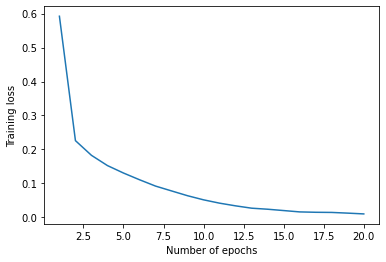

In [23]:
plt.plot(range(1,num_epochs+1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")

In [24]:
save_path = 'RESNET18_finetuning_the_convnet.pth'
torch.save(model.state_dict(), save_path)

In [25]:
train_loss_dict['RESNET18_finetuning_the_convnet']=train_loss_list
test_loss_dict['RESNET18_finetuning_the_convnet']=test_loss_list

### model3 - RESNET18_ConvNet_as_fixed_feature_extractor

In [26]:
model = models.resnet18(weights=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, 6)
model = model.to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [27]:
train_loss_list, test_loss_list = training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader)

Epoch 0 running
[Train #0] Loss: 0.8551 Acc: 73.5357% Time: 367.6828s
[Test #0] Loss: 0.4619 Acc: 86.9333% Time: 443.0632s
Epoch 1 running
[Train #1] Loss: 0.4122 Acc: 88.0504% Time: 808.0169s
[Test #1] Loss: 0.3652 Acc: 88.3667% Time: 884.1446s
Epoch 2 running
[Train #2] Loss: 0.3513 Acc: 89.1620% Time: 1249.0537s
[Test #2] Loss: 0.3325 Acc: 88.9000% Time: 1324.7768s
Epoch 3 running
[Train #3] Loss: 0.3241 Acc: 89.7677% Time: 1689.1514s
[Test #3] Loss: 0.3141 Acc: 89.3333% Time: 1764.1237s
Epoch 4 running
[Train #4] Loss: 0.3070 Acc: 89.9815% Time: 2129.0767s
[Test #4] Loss: 0.3011 Acc: 89.4667% Time: 2205.1847s
Epoch 5 running
[Train #5] Loss: 0.2967 Acc: 90.1810% Time: 2570.7730s
[Test #5] Loss: 0.2916 Acc: 89.3667% Time: 2646.4563s
Epoch 6 running
[Train #6] Loss: 0.2867 Acc: 90.4233% Time: 3011.0463s
[Test #6] Loss: 0.2863 Acc: 89.8667% Time: 3089.6092s
Epoch 7 running
[Train #7] Loss: 0.2790 Acc: 90.6869% Time: 3459.1193s
[Test #7] Loss: 0.2786 Acc: 89.9333% Time: 3535.0194s
Epoc

Text(0, 0.5, 'Training loss')

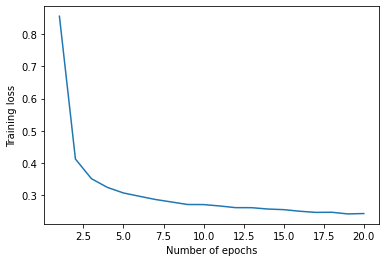

In [28]:
plt.plot(range(1,num_epochs+1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")

In [29]:
save_path = 'RESNET18_ConvNet_as_fixed_feature_extractor.pth'
torch.save(model.state_dict(), save_path)

In [30]:
train_loss_dict['RESNET18_ConvNet_as_fixed_feature_extractor']=train_loss_list
test_loss_dict['RESNET18_ConvNet_as_fixed_feature_extractor']=test_loss_list

### model4 - RESNET18_ConvNet_as_fixed_feature_extractor + AutoAugment

In [40]:
train_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.AutoAugment(),transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

In [41]:
train_dataset = ImageFolder('C:/Users/Aleksei_Bolshukhin/Desktop/computer_vision/2/Classification_data/Classification_data/train',
                      transform = train_transforms)
test_dataset = ImageFolder('C:/Users/Aleksei_Bolshukhin/Desktop/computer_vision/2/Classification_data/Classification_data/test',
                      transform = test_transforms)

In [42]:
model = models.resnet18(weights=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, 6)
model = model.to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [43]:
train_loss_list, test_loss_list = training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader)

Epoch 0 running
[Train #0] Loss: 0.8302 Acc: 74.3979% Time: 377.1295s
[Test #0] Loss: 0.4420 Acc: 88.7000% Time: 456.1243s
Epoch 1 running
[Train #1] Loss: 0.4056 Acc: 88.3212% Time: 832.7810s
[Test #1] Loss: 0.3510 Acc: 89.5333% Time: 910.0555s
Epoch 2 running
[Train #2] Loss: 0.3458 Acc: 89.4471% Time: 1287.6052s
[Test #2] Loss: 0.3189 Acc: 90.2333% Time: 1365.7139s
Epoch 3 running
[Train #3] Loss: 0.3213 Acc: 89.8817% Time: 1745.0177s
[Test #3] Loss: 0.3002 Acc: 90.3333% Time: 1822.2004s
Epoch 4 running
[Train #4] Loss: 0.3031 Acc: 90.1311% Time: 2202.1533s
[Test #4] Loss: 0.2926 Acc: 90.3667% Time: 2280.1831s
Epoch 5 running
[Train #5] Loss: 0.2916 Acc: 90.4731% Time: 2656.2344s
[Test #5] Loss: 0.2808 Acc: 90.4000% Time: 2734.5180s
Epoch 6 running
[Train #6] Loss: 0.2855 Acc: 90.5373% Time: 3111.6688s
[Test #6] Loss: 0.2768 Acc: 90.4000% Time: 3189.1431s
Epoch 7 running
[Train #7] Loss: 0.2778 Acc: 90.7012% Time: 3567.2359s
[Test #7] Loss: 0.2745 Acc: 90.4000% Time: 3644.3415s
Epoc

In [44]:
save_path = 'RESNET18_ConvNet_as_fixed_feature_extractor_and_AutoAugment.pth'
torch.save(model.state_dict(), save_path)

In [45]:
train_loss_dict['RESNET18_ConvNet_as_fixed_feature_extractor_and_AutoAugment']=train_loss_list
test_loss_dict['RESNET18_ConvNet_as_fixed_feature_extractor_and_AutoAugment']=test_loss_list

## Comparing models

Text(0, 0.5, 'Training loss')

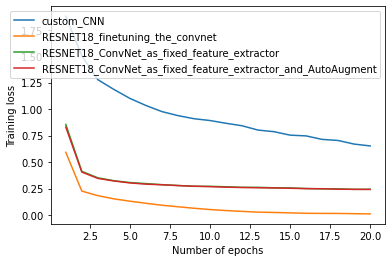

In [48]:
plt.figure().clear()
for i in train_loss_dict.keys():
    plt.plot(range(1,num_epochs+1), train_loss_dict[i], label=i)
plt.legend(train_loss_dict.keys())    
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")

Text(0, 0.5, 'Validation loss')

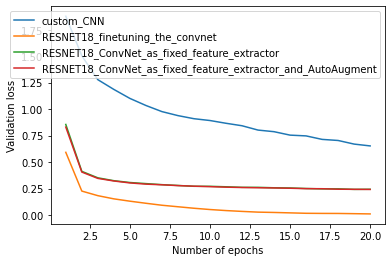

In [50]:
for i in test_loss_dict.keys():
    plt.plot(range(1,num_epochs+1), train_loss_dict[i], label=i)
plt.legend(train_loss_dict.keys())    
plt.xlabel("Number of epochs")
plt.ylabel("Validation loss")